# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:

whole_sale = pd.read_csv("../data/Wholesale customers data.csv")

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Your code here:
whole_sale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
whole_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


In [5]:
whole_sale.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [6]:
whole_sale.shape

(440, 8)

In [7]:
whole_sale.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

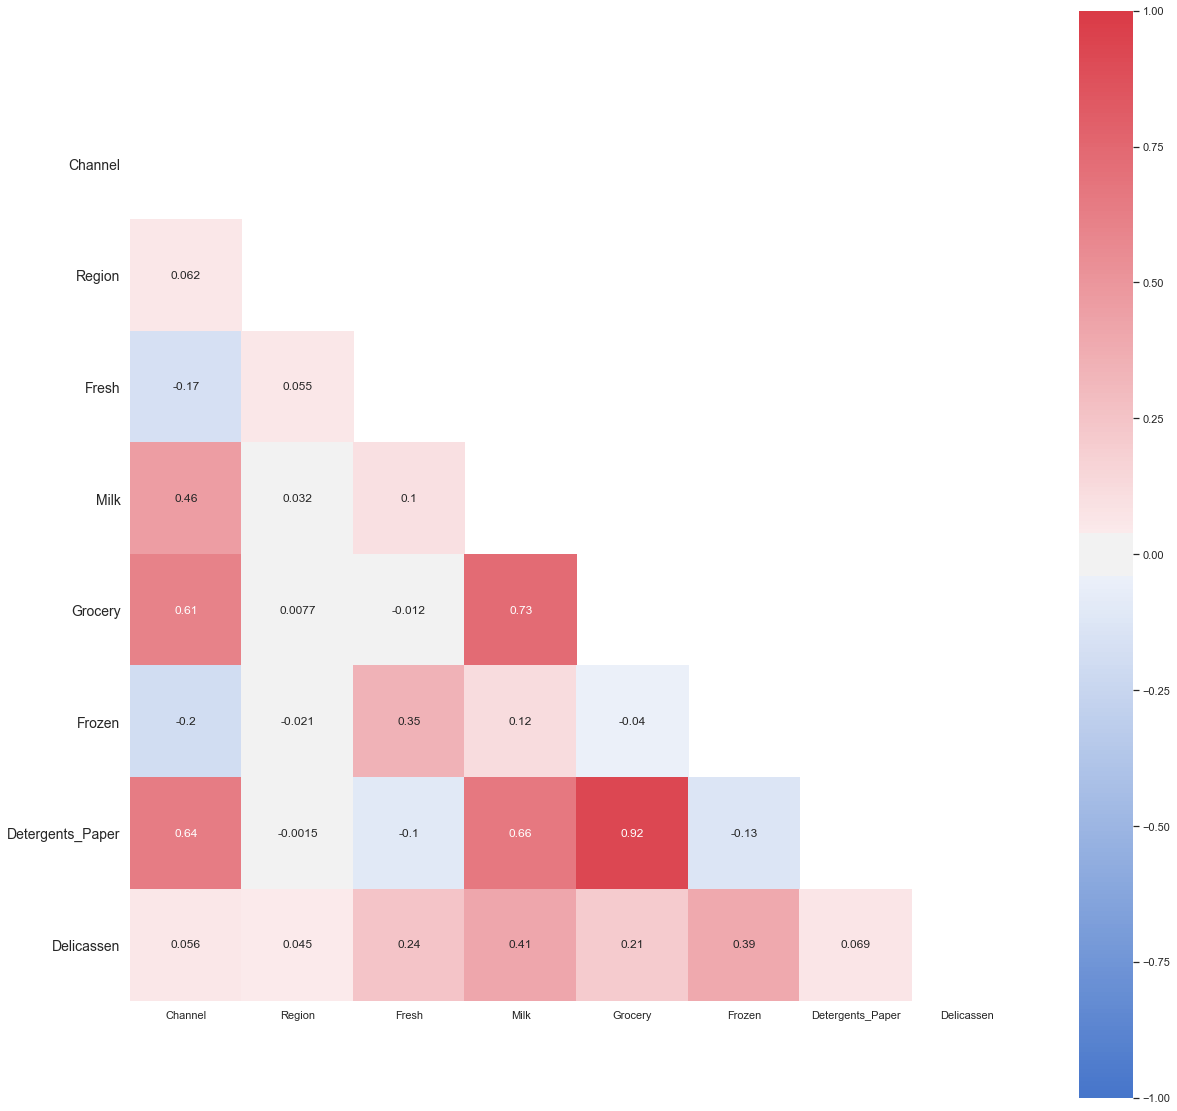

In [8]:
# Your code here
sns.set(style="white")
    
# Generate a mask for the upper triangle
mask = np.zeros_like(whole_sale.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(20,20))

# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors

# Plot the heatmap
g = sns.heatmap(whole_sale.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1, ax=ax)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 14)
plt.show()

In [9]:
# Function to get sum number of values from these columns for each row
continous_columns = ["Fresh", "Milk", "Grocery", "Frozen"]

def get_columns_sum(x):
    num = [x[column].sum() for column in continous_columns]
    return sum(num)

In [10]:
# We make a copy to don't make a conflict with posterior modelling
pareto_distribution = whole_sale.copy()

In [11]:
# We create new columns, first one to count total values from each column, second to get the percentage of these value to total
pareto_distribution['total_count'] = pareto_distribution.apply(lambda x: get_columns_sum(x),axis=1)
pareto_distribution['pareto'] = 100 * (pareto_distribution.total_count / get_columns_sum(whole_sale))

In [12]:
# Function to determine the 20% of rows a dataset has
def get_twenty_percent_rows():
    return pareto_distribution.shape[0] * 0.2 

In [13]:
# We confirm our sum of pareto columns is 100%.
pareto_distribution.pareto.sum()

100.0

In [14]:
# We order dataset by these value
pareto_distribution.pareto.sort_values(ascending=False)

181    1.393228
47     1.278147
85     1.231162
183    1.084333
61     1.081667
         ...   
131    0.026418
355    0.025030
98     0.018043
97     0.016095
154    0.007011
Name: pareto, Length: 440, dtype: float64

In [15]:
eighty_percent = int(get_twenty_percent_rows())
pareto_distribution.pareto.sort_values(ascending=False)[eighty_percent:].sum()

57.30411570339177

In [16]:
# 20 % of values contains 57% of total values. 

In [17]:
# Your observations here

# What does each column mean?

    # Channel - Customer channel    
    # Region - Customer region        
    # Fresh - Annual spending on fresh products              
    # Milk - Annual spending on Milk products             
    # Grocery - Annual spending on Grocery products             
    # Frozen - Annual spending on Frozen products             
    # Detergents_Paper - Annual spending on detergent and paper products 
    # Delicassen - Annual spending on Delicassen products        

# Any categorical data to convert?
    # No, majority of our data is continous and does not provide any category.
# Any missing data to remove?
    # Surprisingly there is no missing data
# Column collinearity - any high correlations?
    # Yes, Detergent Paper and Grocery have a pretty high correlation. It means they both are the top sales? It makes sense as the first one is imprescindible, but the second one...
# Descriptive statistics - any outliers to remove?
    # Seems there is no outliers as columns are continuous. It's possible there is somebody spending these amounts of money on groceries...
# Column-wise data distribution - is the distribution skewed?
    # Is based on each costumer, so I would say no.

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [18]:
# Your code here

# As explained before, we do not need to clean or transform dataset.

In [19]:
# Your comment here

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [20]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:

customers_scale = StandardScaler().fit_transform(whole_sale[continous_columns])

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [21]:
# Your code here:

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit(customers_scale)

Count the values in `labels`.

In [22]:
# Your code here:
print(len(labels.labels_))

440


In [23]:
whole_sale["labels"] = labels.labels_

In [24]:
whole_sale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
0,2,3,12669,9656,7561,214,2674,1338,2
1,2,3,7057,9810,9568,1762,3293,1776,2
2,2,3,6353,8808,7684,2405,3516,7844,2
3,1,3,13265,1196,4221,6404,507,1788,2
4,2,3,22615,5410,7198,3915,1777,5185,0


# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [25]:
# Your code here

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5)
labels_dbscan = dbscan.fit(customers_scale)

Count the values in `labels_DBSCAN`.

In [26]:
# Your code here
print(len(labels_dbscan.labels_))

440


In [27]:
whole_sale["labels_DBSCAN"] = labels_dbscan.labels_

In [28]:
whole_sale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,2,0
1,2,3,7057,9810,9568,1762,3293,1776,2,0
2,2,3,6353,8808,7684,2405,3516,7844,2,0
3,1,3,13265,1196,4221,6404,507,1788,2,0
4,2,3,22615,5410,7198,3915,1777,5185,0,0


# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

In [29]:
clustering_columns = ["labels", "labels_DBSCAN"]

In [30]:
def visualize(x, y):
    for k in clustering_columns:
        ax = sns.scatterplot(
            x=x,
            y=y,
            hue=k,
            data=whole_sale
        )
        plt.show()

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

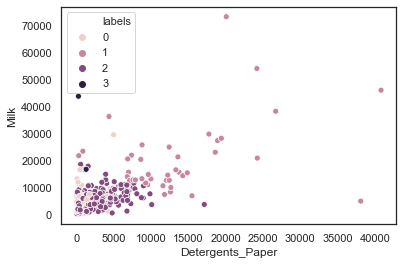

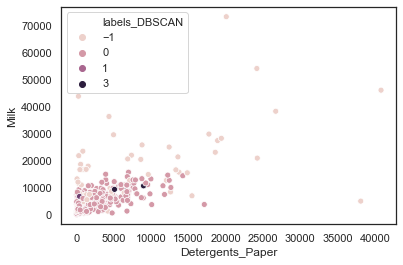

In [31]:
# Your code here:
visualize("Detergents_Paper", "Milk")

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

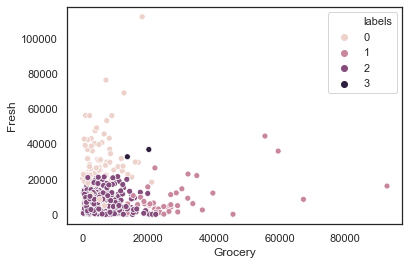

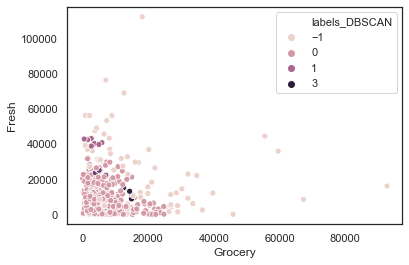

In [32]:
# Your code here:
visualize("Grocery", "Fresh")

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

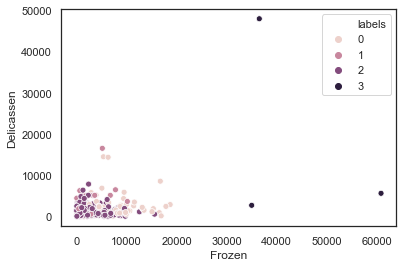

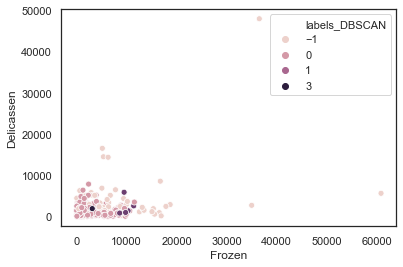

In [33]:
# Your code here:
visualize("Frozen", "Delicassen")

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [55]:
# Your code here:
whole_sale.groupby(["labels"]).mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
labels,,,,,,,,,
0,1.134146,2.609756,30529.695122,4521.073171,5365.707317,6100.000000,979.073171,2137.792683,-0.195122
1,1.954545,2.431818,8456.522727,20005.272727,28692.659091,2167.909091,12844.522727,2446.340909,-0.636364
2,1.286174,2.540193,7471.803859,3972.903537,5659.932476,2005.305466,1996.244373,1066.736334,-0.003215
3,1.000000,2.666667,26959.333333,21274.666667,11952.666667,44137.333333,527.333333,18750.000000,-1.000000


In [54]:
whole_sale.groupby(["labels_DBSCAN"]).mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
labels_DBSCAN,,,,,,,,,
-1,1.445946,2.581081,23044.405405,14207.959459,17414.216216,7326.216216,6542.378378,3525.067568,0.77027
0,1.299145,2.521368,8916.031339,4074.623932,6050.948718,2119.769231,2150.133903,1102.603989,1.74359
1,1.285714,3.000000,41090.428571,2138.000000,3095.571429,1182.571429,741.571429,1062.428571,0.00000
2,1.000000,2.600000,24117.200000,4652.000000,4535.800000,9932.200000,655.800000,2318.200000,0.00000
3,1.666667,3.000000,12366.333333,10183.000000,13893.000000,2510.666667,6851.333333,1348.666667,2.00000


Which algorithm appears to perform better?

In [36]:
# Your observations here

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [37]:
# Your code here

In [38]:
# Your comment here

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [39]:
# Your code here

In [40]:
# Your comment here